# Social Media Analytics

Master's Degree in Data Science (A.Y. 2021/2022)

In [1]:
!pip install demoji

     |████████████████████████████████| 42 kB 911 kB/s 


In [2]:
!pip install NRCLex

     |████████████████████████████████| 396 kB 24.5 MB/s 
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=0f2c1e718da1f9b2b98ae85bae55a557c1f211ecacabf9f386538a01e8c413c1
  Stored in directory: /root/.cache/pip/wheels/af/2c/9c/dfa19d1b65326c520b32850a9311f6d4eda679ac04dba26081
Successfully built NRCLex


In [3]:
!pip install igraph

     |████████████████████████████████| 3.1 MB 15.6 MB/s 


In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from scipy import stats
from operator import itemgetter
import itertools 
from networkx.algorithms.community.centrality import girvan_newman
import networkx as nx
import igraph
import demoji
import re
import string
import unicodedata
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from nrclex import NRCLex

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

sns.set()

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Caricamento dati Paralimpiadi

In [5]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Load data
path='gdrive/MyDrive/Social Media Analytics/Tweets/paralimpiadi/all_paralympics.json'
tweets = pd.read_json(path)

In [7]:
tweets.head()

,Datetime,TweetId,Text,Username,UserVerified,UserId,UserFollowers,ReplyCount,RetweetCount,LikeCount,QuoteCount,Language,Retweeted,Quoted,Mentioned
0,2021-09-05 23:55:39,1434666570173882368,Boston Athlete Paralympic News - @TeamUSA take...,bostonathletema,False,1068188827280441345,678,0,0,1,0,en,NaN,TeamUSA,"[TeamUSA, Paralympics]"
1,2021-09-05 23:51:27,1434665511116103680,"Thank you, Japan, for hosting the 2020 Olympic...",realCharlesWong,False,853617654241808385,4,0,0,0,0,en,NaN,None,None
2,2021-09-05 23:42:17,1434663203758219272,@Devin_Heroux Thank you so much for sharing yo...,orientthis,False,417481141,145,0,0,3,0,en,NaN,None,[Devin_Heroux]
3,2021-09-05 23:34:42,1434661296239169538,Goodbye #Tokyo2020 Thank you for the memories ...,OksanaMasters,True,633055105,5757,5,7,95,5,en,NaN,None,None
4,2021-09-05 23:31:17,1434660434821402629,@Devin_Heroux Thank you again for everything #...,pkmcgb,False,26031556,107,0,0,1,0,en,NaN,None,[Devin_Heroux]


In [8]:
print('Sono presenti {0} tweet'.format(str(len(tweets))))

Sono presenti 71327 tweet


### Esplorazione dataset

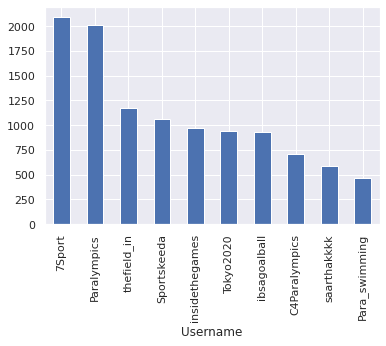

In [ ]:
# Users by tweets count
plt.figure(figsize=(6,4))
tweets.groupby('Username').count().sort_values(by='Datetime', ascending=False)['Datetime'][0:10].plot.bar()

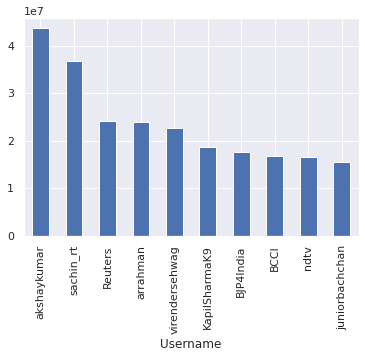

In [ ]:
# Users by followers count
plt.figure(figsize=(6,4))
tweets.groupby('Username')['UserFollowers'].max().sort_values(ascending=False)[0:10].plot.bar()

In [ ]:
# Tweets by likes count
tweets.sort_values(by='LikeCount', ascending=False).head()

,Datetime,TweetId,Text,Username,UserVerified,UserId,UserFollowers,ReplyCount,RetweetCount,LikeCount,QuoteCount,Language,Retweeted,Quoted,Mentioned
41389,2021-08-30 03:53:45,1432189775461564420,Congratulations #AvaniLekhara for hitting the ...,akshaykumar,True,31348594,43680491,537,3940,56777,121,en,NaN,None,None
35787,2021-08-30 13:23:47,1432333227784491021,Yet another #Gold for India! Heartiest congrat...,akshaykumar,True,31348594,43680467,632,2707,42446,69,en,NaN,None,None
42399,2021-08-30 02:57:54,1432175717739995140,She has created history. \nThe first ever woma...,virendersehwag,True,92724677,22652192,150,4318,41808,143,en,NaN,None,None
37771,2021-08-30 11:03:09,1432297835278569475,SPEECHLESS 🤩\n\n🔥 Sumit Antil sets a WR with h...,OlympicKhel,True,1218945528676876288,126221,367,7871,35600,1029,en,NaN,None,None
48398,2021-08-29 05:40:19,1431854204541231106,"Thank you for making history with your medal, ...",akshaykumar,True,31348594,43680925,392,2082,31402,54,en,NaN,None,None


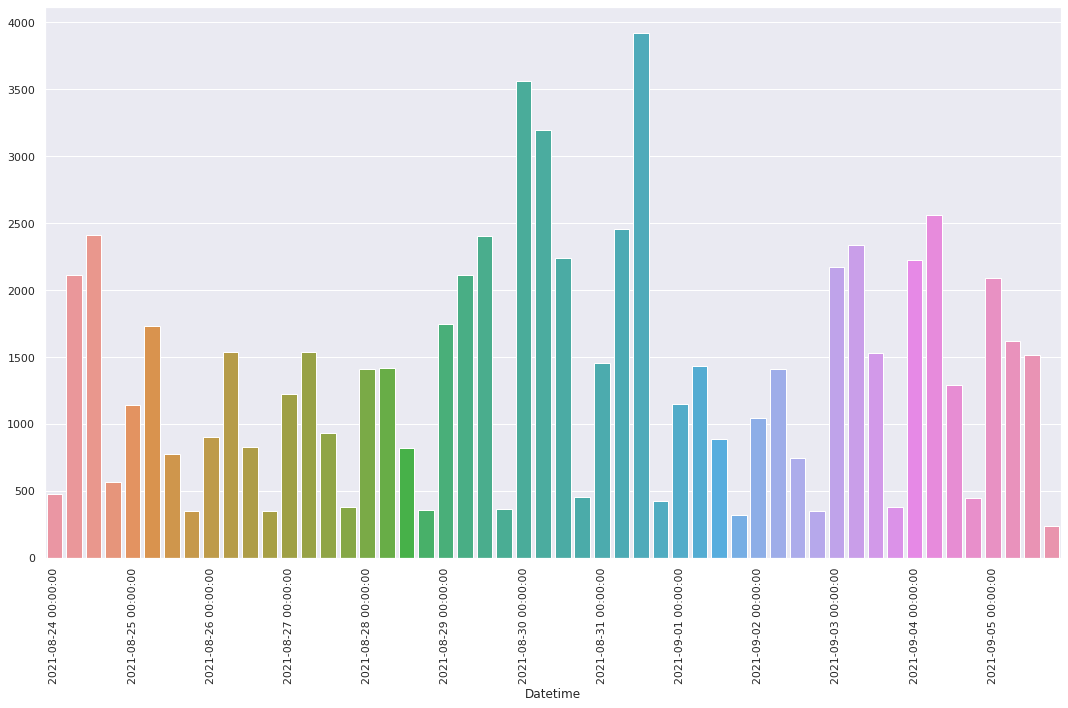

In [ ]:
# Tweets count by date (6H slice)
dates = tweets.groupby(pd.Grouper(key='Datetime', freq='6H'))['Text'].count().index
x = []
for date in dates:
        x.append(str(date.date()))
y = tweets.groupby(pd.Grouper(key='Datetime', freq='6H'))['Text'].count().values
plt.figure(figsize=(15, 10))
bar_plot = sns.barplot(x = dates, y= y)
plt.xticks(rotation=90)

# Plot x label once every 4 tic
for index, label in enumerate(bar_plot.get_xticklabels()):
    if index % 4 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.tight_layout()

## Social Network Analysis

In [ ]:
df_net = tweets[['Username', 'Retweeted', 'Quoted', 'Mentioned']].dropna(axis=0, how='all', subset=['Retweeted', 'Quoted', 'Mentioned']).copy()

In [ ]:
df_net

,Username,Retweeted,Quoted,Mentioned
0,bostonathletema,NaN,TeamUSA,"[TeamUSA, Paralympics]"
2,orientthis,NaN,None,[Devin_Heroux]
4,pkmcgb,NaN,None,[Devin_Heroux]
5,ausportsmuseum,NaN,AUSParalympics,None
7,DFATQLD,NaN,AUSParalympics,"[AUSParalympics, CGJapanBNE]"
...,...,...,...,...
71318,Sporting_Tragic,NaN,abcsport,[abcsport]
71319,AlliC19,NaN,None,"[AUSOlympicTeam, AUSParalympics]"
71321,AUSOlympicTeam,NaN,None,[AUSParalympics]
71324,AustraliaInJPN,NaN,None,"[AUSParalympics, sports_tokyo]"


In [ ]:
# Build the graph
G = nx.Graph()
for i in range(len(df_net)):
  if (df_net['Quoted'].iloc[i] is not None) and (df_net['Username'].iloc[i]!=df_net['Quoted'].iloc[i]):
    G.add_edge(df_net['Username'].iloc[i], df_net['Quoted'].iloc[i])

In [ ]:
# Largest connected subgraph
largest_subgraph = max([G.subgraph(c) for c in nx.connected_components(G)], key=len)

In [ ]:
# Save graph
nx.write_gexf(largest_subgraph, "/content/gdrive/MyDrive/Social Media Analytics/paralympics.gexf")

### Analisi del grafo

In [ ]:
print(f"Il grafo ha {G.number_of_nodes()} nodi e {G.number_of_edges()} archi")

Il grafo ha 5340 nodi e 5642 archi


In [ ]:
degrees = [val for (node, val) in G.degree()]

In [ ]:
print(f"Il nodo con grado massimo di G è '{list(G.nodes)[np.argmax(degrees)]}', corrispondente al valore {np.max(degrees)}")   
print(f"Il grado minimo di G è  {np.min(degrees)}")  

Il nodo con grado massimo di G è 'Tokyo2020', corrispondente al valore 599
Il grado minimo di G è  1


In [ ]:
print(f"Il grado medio dei nodi di G è {np.mean(degrees):.1f}")  
print(f"Il grado più frequente dei nodi di G è {stats.mode(degrees)[0][0]}") 

Il grado medio dei nodi di G è 2.1
Il grado più frequente dei nodi di G è 1


In [ ]:
if nx.is_connected(G):
    print("Il grafo è connesso")
else:
    print("Il grafo non è connesso")

Il grafo non è connesso


In [ ]:
print(f"Ci sono {nx.number_connected_components(G)} componenti connesse in G")  

Ci sono 626 componenti connesse in G


In [ ]:
print(f"Ci sono {largest_subgraph.number_of_nodes()} nodi e {largest_subgraph.number_of_edges()} \
archi nella più grande componente connessa di G")

Ci sono 3825 nodi e 4750 archi nella più grande componente connessa di G


In [ ]:
print(f"Il coefficiente di clustering medio è {nx.average_clustering(G)} all'interno di G")
print(f"La transitività all'interno di G {nx.transitivity(G)}")

Il coefficiente di clustering medio è 0.03486939171374188 all'interno di G
La transitività all'interno di G 0.0035724264559134633


In [ ]:
print(f"Il coefficiente di clustering medio è {nx.average_clustering(largest_subgraph)} all'interno della componente connessa più grande di G")
print(f"La transitività all'interno della componente connessa più grande di G {nx.transitivity(largest_subgraph)}")

Il coefficiente di clustering medio è 0.0475300788892501 all'interno della componente connessa più grande di G
La transitività all'interno della componente connessa più grande di G 0.003563056103148809


In [ ]:
top5degree = np.argpartition(degrees, -5)[-5:]
for ind in top5degree:
  print(f"Degree centrality di '{list(G.nodes)[ind]}': {nx.degree_centrality(largest_subgraph)[list(G.nodes)[ind]]}")  
print('-----------------------------------------------')
for ind in top5degree:
  print(f"Closeness centrality di '{list(G.nodes)[ind]}': {nx.closeness_centrality(largest_subgraph, u=list(G.nodes)[ind])}")  

Degree centrality di 'ddsportschannel': 0.0549163179916318
Degree centrality di 'C4Paralympics': 0.0711297071129707
Degree centrality di 'OlympicKhel': 0.08315899581589957
Degree centrality di 'Paralympics': 0.11375523012552301
Degree centrality di 'Tokyo2020': 0.15664225941422594
-----------------------------------------------
Closeness centrality di 'ddsportschannel': 0.3216959703878186
Closeness centrality di 'C4Paralympics': 0.32267319213568474
Closeness centrality di 'OlympicKhel': 0.35960127891668237
Closeness centrality di 'Paralympics': 0.39491893008365175
Closeness centrality di 'Tokyo2020': 0.38552273414658733


### Community Detection

In [ ]:
g_igraph = igraph.Graph.from_networkx(largest_subgraph)

#### Fast greedy

In [ ]:
c1 = g_igraph.community_fastgreedy()

In [ ]:
num_communities = c1.optimal_count
clusters = c1.as_clustering(num_communities)
communities = clusters.membership

In [ ]:
max(communities)+1

54

In [ ]:
print(clusters.modularity)

0.788582448753463


#### Louvain

In [ ]:
c2 = g_igraph.community_multilevel()

In [ ]:
communities = c2.membership

In [ ]:
max(communities)+1

27

In [ ]:
print(c2.modularity)

0.7970707146814404


#### Leadeing eigenvector

In [ ]:
c3 = g_igraph.community_leading_eigenvector()

In [ ]:
communities = c3.membership

In [ ]:
max(communities)+1

30

In [ ]:
print(c3.modularity)

0.687418659279778


#### Walktrap

In [ ]:
c4 = g_igraph.community_walktrap()

In [ ]:
num_communities = c4.optimal_count
clusters = c4.as_clustering(num_communities)
communities = clusters.membership

In [ ]:
max(communities)+1

148

In [ ]:
print(clusters.modularity)

0.7326165096952922


### Assortativity


In [ ]:
g_igraph.assortativity_degree()

-0.28218529030209405

## Social Content Analysis

### Preprocessing

In [ ]:
df_sentiment = tweets[['Datetime', 'Text']].copy()

In [ ]:
####################################
# Functions for data preprocessing #
####################################

# Replace emojis with their description
def replace_emoji(text):
  return demoji.replace_with_desc(text," ")
  

# Replace compact forms with complete forms
def replace_words(data_text):
    data_text = data_text.replace('\n','').\
                                      replace('won\'t','will not').\
                                      replace('n\'t',' not').\
                                      replace('\'d',' would').\
                                      replace('\'s',' is').\
                                      replace('\'m',' am').\
                                      replace('\'ll',' will').\
                                      replace('\'ve',' have').\
                                      replace('\'re',' are').\
                                      replace('ying','y').\
                                      replace('<br/>','')
    
    return data_text

# Remove URL
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

# Remove numbers and symbols
def remove_num_symb(data):
    data = data.replace('[^\w\s]',' ').\
              replace('\.',' ').\
              replace('\d+',' ')
    return data

# Remove stop words
def remove_stopwords(text, stop_words=None):
    if stop_words is None:
        stop_words = stopwords.words('english')
    return ' '.join([word for word in text.split() if word not in stop_words])

# Remove extra spaces
def remove_extra_whitespace(text):
    return " ".join(text.split())

# Remove punctuation
def remove_punctuation(text, punctuation=None):
  if punctuation is None:
      punctuation = string.punctuation
  return text.translate(str.maketrans(punctuation, ' '*len(punctuation)))


# POS tagging
def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

# Lemmatizzation
def lemmaSentence(text, lemmatizer):
    lemma_text = ''
    tok_text = word_tokenize(text)
    tags = get_wordnet_pos(tok_text)
    for i in range(len(tok_text)):
        lemma_text = lemma_text + ' ' + lemmatizer.lemmatize(tok_text[i], tags[i])
    return lemma_text[1:]

In [ ]:
def preprocess(text):
    text = text.lower()
    text = remove_urls(text)
    text = replace_words(text)
    text = replace_emoji(text)
    text = text.lower()
    # Remove words that are digits only
    text = re.sub(r'\b\d+\b', '', text)
    text = remove_extra_whitespace(text)
    text = remove_punctuation(text)
    text = remove_num_symb(text)
    text = remove_stopwords(text)

    # Lemmatization with POS tagging
    text = lemmaSentence(text, WordNetLemmatizer())

    return text

In [ ]:
df_sentiment['Preprocessed']=df_sentiment['Text'].apply(preprocess)

In [ ]:
df_sentiment.dropna(axis=0, inplace=True)

In [ ]:
df_sentiment.head()

,Datetime,Text,Preprocessed
0,2021-09-05 23:55:39,Boston Athlete Paralympic News - @TeamUSA take...,boston athlete paralympic news teamusa take ho...
1,2021-09-05 23:51:27,"Thank you, Japan, for hosting the 2020 Olympic...",thank japan host olympic paralympic game felt ...
2,2021-09-05 23:42:17,@Devin_Heroux Thank you so much for sharing yo...,devin heroux thank much sharing energy passion...
3,2021-09-05 23:34:42,Goodbye #Tokyo2020 Thank you for the memories ...,goodbye tokyo2020 thank memory
4,2021-09-05 23:31:17,@Devin_Heroux Thank you again for everything #...,devin heroux thank everything tokyo2020 paraly...


### Sentiment Analysis

In [ ]:
# Vader sentiment analyzer
sid = SentimentIntensityAnalyzer()

In [ ]:
df_sentiment['Sentiment'] = df_sentiment['Preprocessed'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [ ]:
# Emotion extractor
def extract_emotions(text):
  emotions = []
  if TextBlob(text).sentiment.subjectivity > 0:
    for emotion in NRCLex(text).top_emotions:
      emotions.append(emotion[0])
  return emotions

In [ ]:
df_sentiment['Emotions'] = df_sentiment['Preprocessed'].apply(extract_emotions)

In [ ]:
df_sentiment.to_json('/content/gdrive/MyDrive/Social Media Analytics/paralympics.json')

In [ ]:
df_sentiment = pd.read_json('/content/gdrive/MyDrive/Social Media Analytics/paralympics.json')

In [ ]:
df_sentiment.head()

,Datetime,Text,Preprocessed,Sentiment,Emotions
0,2021-09-05 23:55:39,Boston Athlete Paralympic News - @TeamUSA take...,boston athlete paralympic news teamusa take ho...,0.8126,[positive]
1,2021-09-05 23:51:27,"Thank you, Japan, for hosting the 2020 Olympic...",thank japan host olympic paralympic game felt ...,0.8658,[positive]
2,2021-09-05 23:42:17,@Devin_Heroux Thank you so much for sharing yo...,devin heroux thank much sharing energy passion...,0.9485,[positive]
3,2021-09-05 23:34:42,Goodbye #Tokyo2020 Thank you for the memories ...,goodbye tokyo2020 thank memory,0.3612,[]
4,2021-09-05 23:31:17,@Devin_Heroux Thank you again for everything #...,devin heroux thank everything tokyo2020 paraly...,0.3612,[]


In [ ]:
print('Valore di sentiment medio: ' + str(df_sentiment['Sentiment'].mean()))

Valore di sentiment medio: 0.46377393974230957


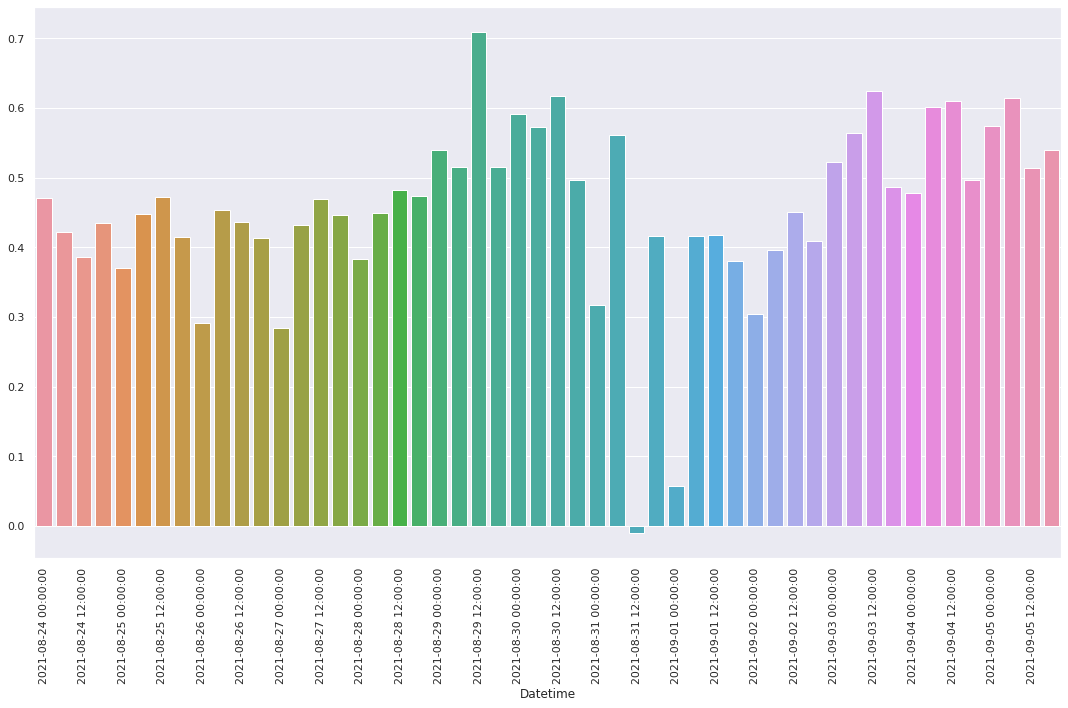

In [ ]:
# Average sentiment value by date (6H slice)
df_sentiment['Datetime'] = pd.to_datetime(df_sentiment['Datetime'])
dates = df_sentiment.groupby(pd.Grouper(key='Datetime', freq='6H'))['Sentiment'].mean().index
x = []
for date in dates:
        x.append(str(date.date()))
y = df_sentiment.groupby(pd.Grouper(key='Datetime', freq='6H'))['Sentiment'].mean().values
plt.figure(figsize=(15, 10))
bar_plot = sns.barplot(x = dates, y= y)
plt.xticks(rotation=90)

for index, label in enumerate(bar_plot.get_xticklabels()):
    if index % 2 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
plt.tight_layout()

### Analisi dei picchi di sentiment

In [ ]:
# Counter emotions
def counter_emotions(df):
  counter = {'anger':0, 'anticipation':0, 'disgust':0, 'fear':0, 'joy':0, 'sadness':0, 'surprise':0, 'trust':0}
  for emotions in df['Emotions'].values:
    for emotion in emotions:
      if emotion in counter:
        counter[emotion] += 1
  return counter

In [ ]:
# Get tweets written during a sentiment peak
df_peak = df_sentiment[(df_sentiment['Datetime']>='2021-08-29 12:00:00') & (df_sentiment['Datetime']<'2021-08-29 18:00:00')].copy()

Mediaglia d'argento India salto in alto - record asiatico

(-0.5, 1023.5, 511.5, -0.5)

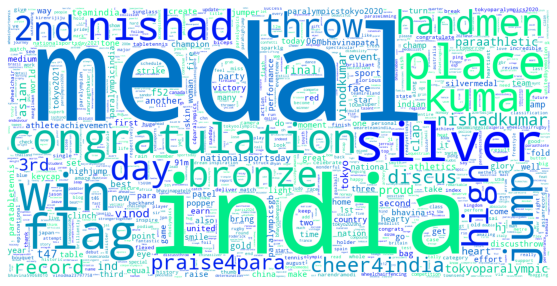

In [ ]:
# Plot wordcloud
fig = plt.figure(figsize=(15, 5))

text = ' '.join(df_peak['Preprocessed'].values)
words = ['tokyo2020', 'paralympic', 'olympics', 'paralympics']
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=words, collocations=False, width=1024, height=512, colormap='winter')
wcloud = wordcloud.generate_from_text(text)
plt.imshow(wcloud)
plt.axis('off')

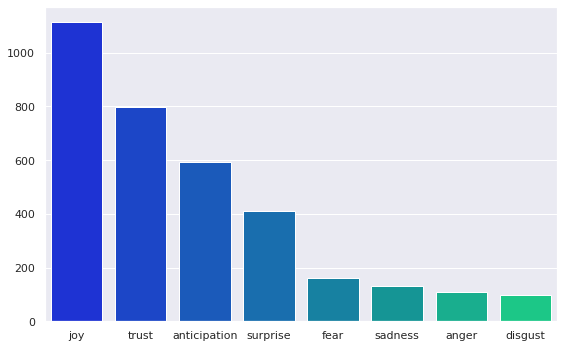

In [ ]:
# Plot barplot emotions
plt.figure(figsize=(8, 5))
emotions = counter_emotions(df_peak)
emotions = dict(sorted(emotions.items(), key=lambda item: item[1], reverse=True))
sns.barplot(x=list(emotions.keys()), y=list(emotions.values()), palette='winter' )
plt.tight_layout()

In [ ]:
# Get tweets written during a sentiment peak
df_peak = df_sentiment[(df_sentiment['Datetime']>='2021-08-31 12:00:00') & (df_sentiment['Datetime']<'2021-08-31 18:00:00')].copy()

Squalifica dell'iniziale vincitore della medaglia d'oro in lancio del peso Zolkefli Muhammad Ziyad per ritardo e assegnazione del premio a Maksym Koval

(-0.5, 1023.5, 511.5, -0.5)

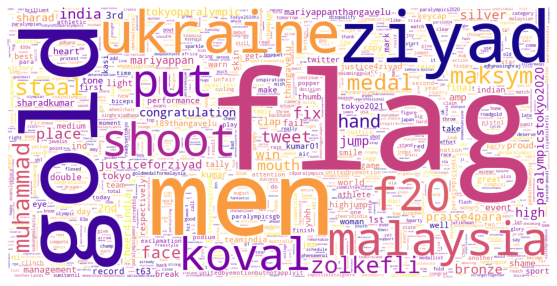

In [ ]:
# Plot wordcloud
fig = plt.figure(figsize=(15, 5))

text = ' '.join(df_peak['Preprocessed'].values)
words = ['tokyo2020', 'paralympic', 'olympics', 'paralympics', 'paraathletics']
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=words, collocations=False, width=1024, height=512, colormap='plasma')
wcloud = wordcloud.generate_from_text(text)
plt.imshow(wcloud)
plt.axis('off')

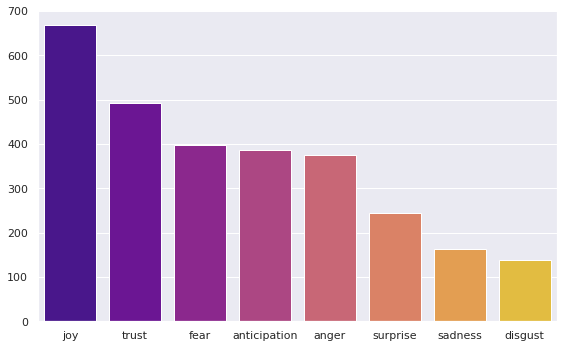

In [ ]:
# Plot barplot emotions
plt.figure(figsize=(8, 5))
emotions = counter_emotions(df_peak)
emotions = dict(sorted(emotions.items(), key=lambda item: item[1], reverse=True))
sns.barplot(x=list(emotions.keys()), y=list(emotions.values()), palette='plasma' )
plt.tight_layout()